<font color="green">**Ensemble model for stock prediction and drift detection**</font>

<font color="blue">**ARIMA model for stock prediction**</font>

**Import libraries**

In [ ]:
#Import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas_datareader as web

**Get stock data and split into train-test datsets**

In [ ]:
#Get the stock quote 
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('DIS', data_source='yahoo', start='2016-07-22', end='2020-05-26') 
#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98
2016-07-27,6.98,6.68,6.93,6.85,38567300,6.85
2016-07-28,6.98,6.74,6.79,6.82,27515600,6.82


In [ ]:
#Train-test split
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

**Build model and predict on testing data**

In [ ]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [ ]:
#Train and test model
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    #print(yhat)
    predictions.append(yhat)
    obs = test_ar[t]
    #history.append(obs)
    history.append(yhat[0])
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 265.926
Symmetric mean absolute percentage error: 21.103


In [ ]:
arima_preds=predictions

**Visualize predictions of Arima**

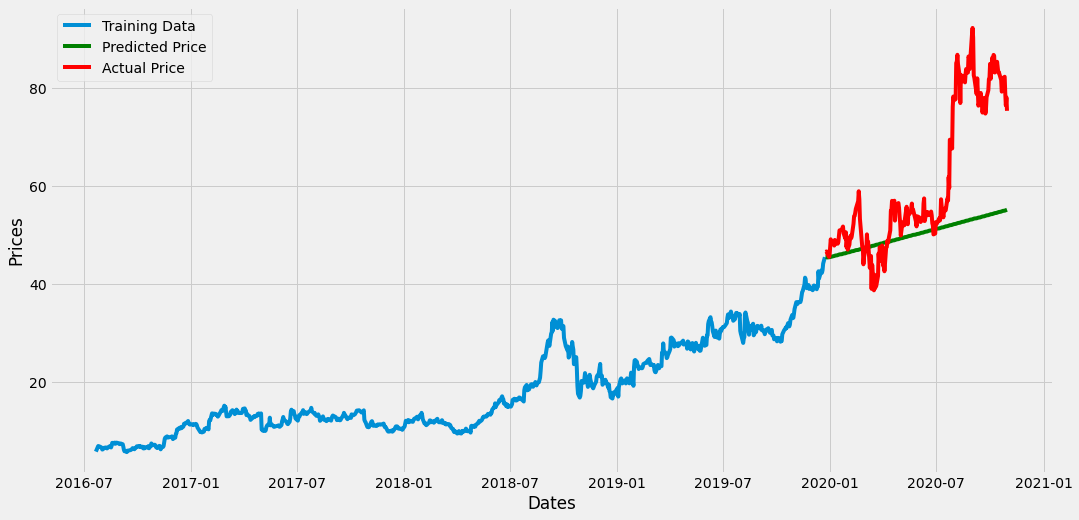

In [ ]:
#Plot data on graph
plt.figure(figsize=(16,8))
plt.plot(train_data['Close'], label='Training Data')
#plt.plot(df['Close'], label='Training Data')
#print(test_data.index)
plt.plot(test_data.index, predictions, color='green', label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

<font color="blue">**LR model**</font>

**Import libraries**

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get data, preprocess and split into train-test dataset**

In [ ]:
#Get the stock quote 
#df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26') 
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-10-30')

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(30,len(train_data)):
  x_train.append(train_data[i-30:i,0])
  y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 30: , : ]
#test_data = scaled_data[training_data_len: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(30,len(test_data)):
  x_test.append(test_data[i-30:i,0])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
x_train.shape

(833, 30)

**Build LR model and train on training data**

In [ ]:
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1])
# print(y_train)
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
x_test.shape

(215, 30)

In [ ]:
x_test=x_test.reshape(x_test.shape[0], x_test.shape[1])

**Predict on testing data using Cross Validation for LR model and visualize predictions**

In [ ]:
#Import libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [ ]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1, 14))}]

# step-3: perform grid search
# 3.1 specify model

rfe = RFE(model,5)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(x_train, y_train)   

Fitting 50 folds for each of 13 candidates, totalling 650 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 650 out of 650 | elapsed:   25.6s finished


GridSearchCV(cv=KFold(n_splits=50, random_state=100, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=5, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [ ]:
#Predictions
preds = model_cv.predict(x_test)
preds = preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)#Undo scaling
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

2.3332759024533796

In [ ]:
LR_preds=preds
LR_rmse=rms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


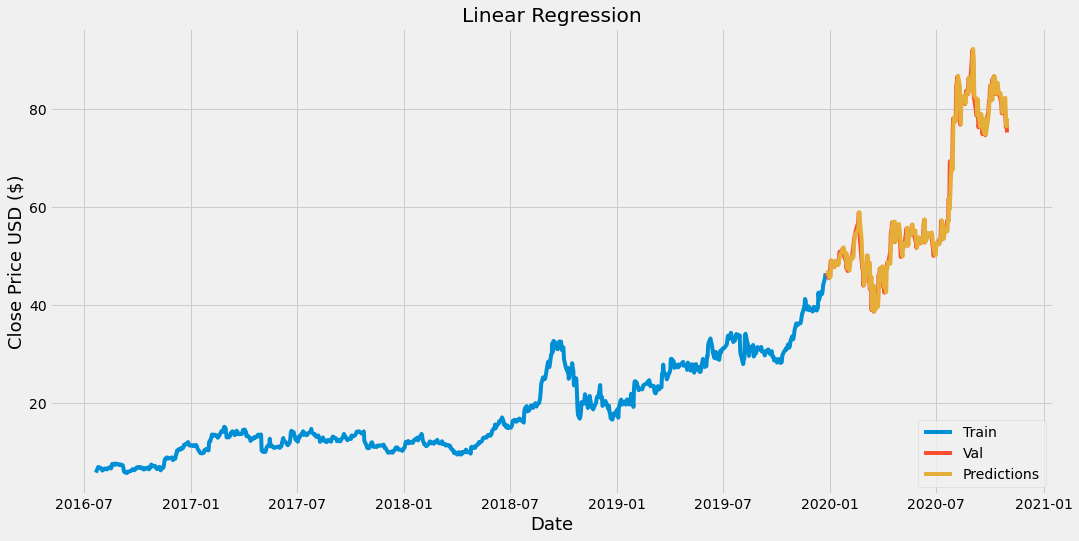

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Linear Regression')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="blue">**KNN model**</font>

**Import libraries, train and test model**

In [ ]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
#using gridsearch to find the best parameter
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11]}
knn = neighbors.KNeighborsRegressor(n_neighbors=20)
model = GridSearchCV(knn, params, cv=15)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_test)
preds = preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)#Undo scaling

#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

22.877159936724702

In [ ]:
knn_preds=preds
knn_rmse=rms

**Visualize predictions of KNN model**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


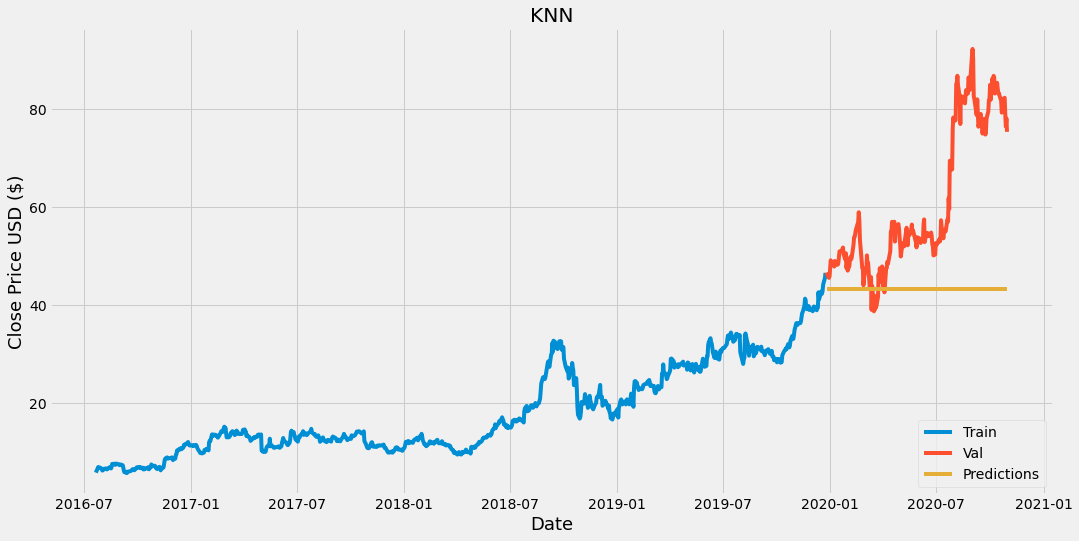

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('KNN')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="blue">**LSTM model**</font>

**Import libraries**

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get stock data and visualize**

In [ ]:
#Get the stock quote 
#df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26') 
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98
2016-07-27,6.98,6.68,6.93,6.85,38567300,6.85
2016-07-28,6.98,6.74,6.79,6.82,27515600,6.82


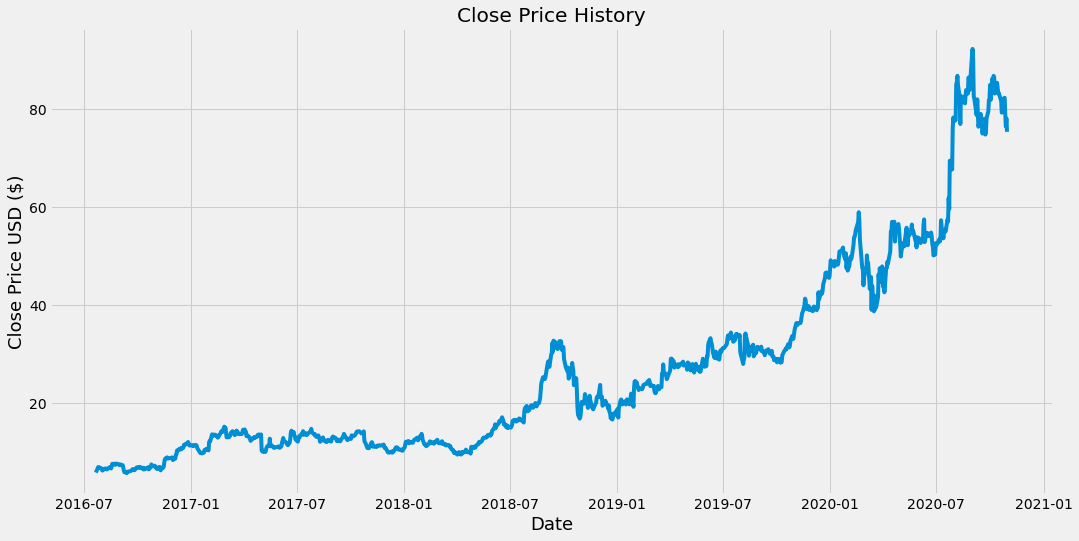

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess stock data and split into train-test split**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

**Build LSTM model and train on training dataset**

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#model.compile(optimizer='adam',loss='mean_absolute_error')

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
803/803 [==============================] - 20s 24ms/step - loss: 6.9643e-04
Epoch 2/5
803/803 [==============================] - 19s 23ms/step - loss: 3.1175e-04
Epoch 3/5
803/803 [==============================] - 19s 23ms/step - loss: 2.3566e-04
Epoch 4/5
803/803 [==============================] - 19s 23ms/step - loss: 2.1631e-04
Epoch 5/5
803/803 [==============================] - 19s 24ms/step - loss: 1.8466e-04


In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

**Predict for LSTM model and visualize predictions**

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [ ]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

2.6796659338838613

In [ ]:
LSTM_preds=predictions
LSTM_rmse=rmse

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


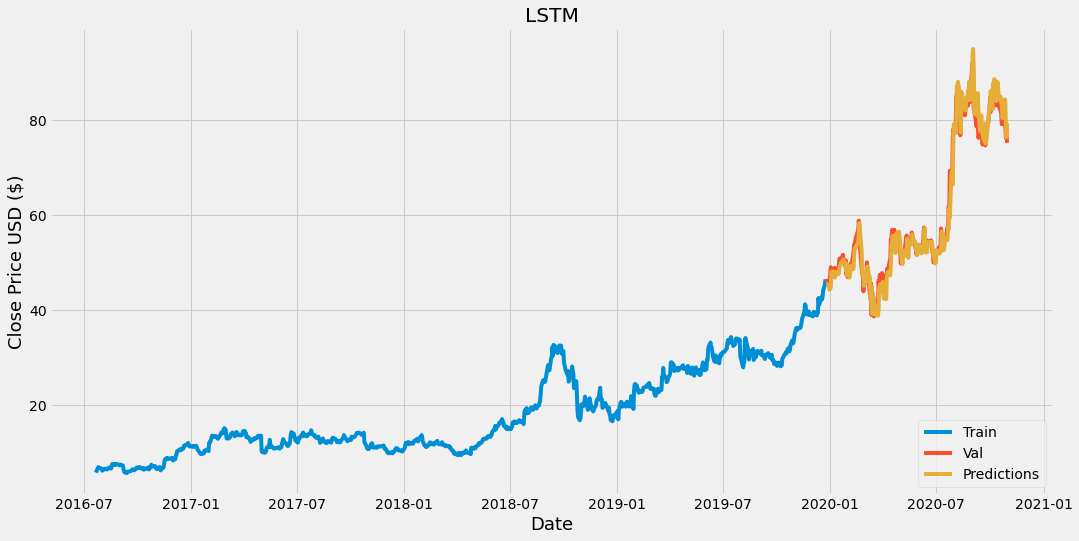

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="blue">**RNN model**</font>

**Import libraries**

In [ ]:
#Import libraries
import math
import time
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as prep
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import GRU
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get stock data and visualize**

In [ ]:
#df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26') 
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98
2016-07-27,6.98,6.68,6.93,6.85,38567300,6.85
2016-07-28,6.98,6.74,6.79,6.82,27515600,6.82


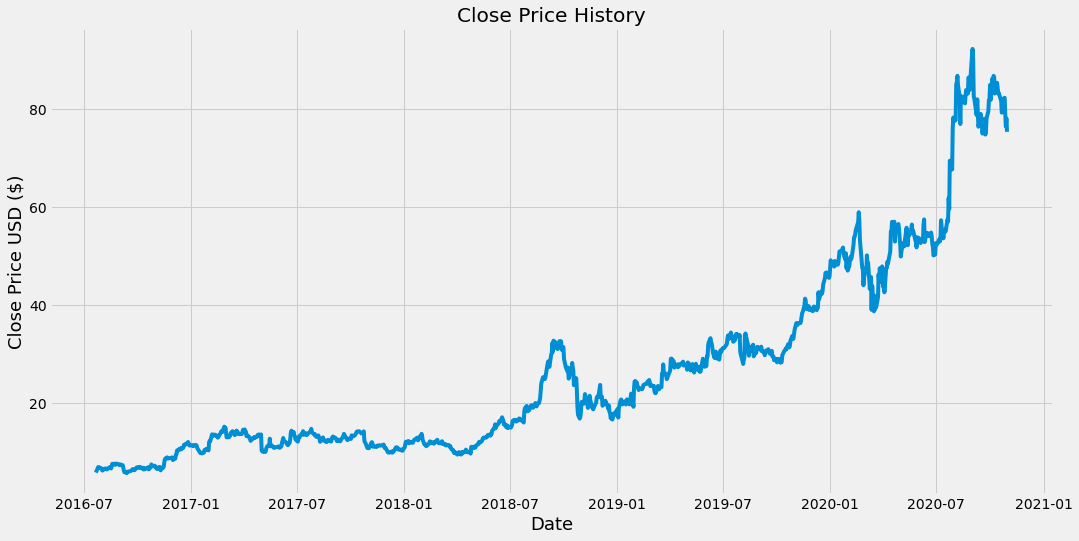

In [ ]:
#Plot data on graph
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess data and split into train-test datasets**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Perform scaling
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#test_data = scaled_data[training_data_len: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
#Reshape data in required format
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

**Build RNN model and train on training data**

In [ ]:
#Build model
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(GRU(units=512, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(GRU(units=256))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (803, 60, 1)
y_train (803,)
X_test (215, 60, 1)
y_test (215, 1)


In [ ]:
window = 60
model = build_model([1, window, 100, 1])

Compilation Time :  0.00678706169128418


In [ ]:
model.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=1)

803/803 [==============================] - 161s 200ms/step - loss: 0.0027 - accuracy: 0.0000e+00


**Predict for RNN model using testing dataset and visualize predictions**

In [ ]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [ ]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

9.403440617521618

In [ ]:
RNN_preds=predictions
RNN_rmse=rmse

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


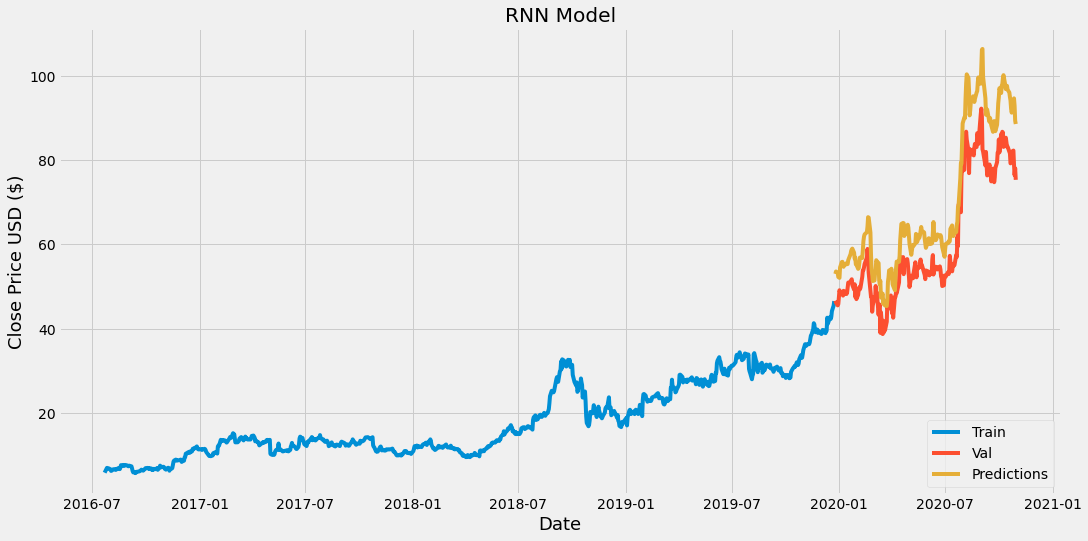

In [ ]:
#Plot data on graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('RNN Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

**Predict for RNN model with batch and visualize predictions**

In [ ]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

9.403440617521618

In [ ]:
RNN_with_batch_preds=predictions
RNN_with_batch_rmse=rmse

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


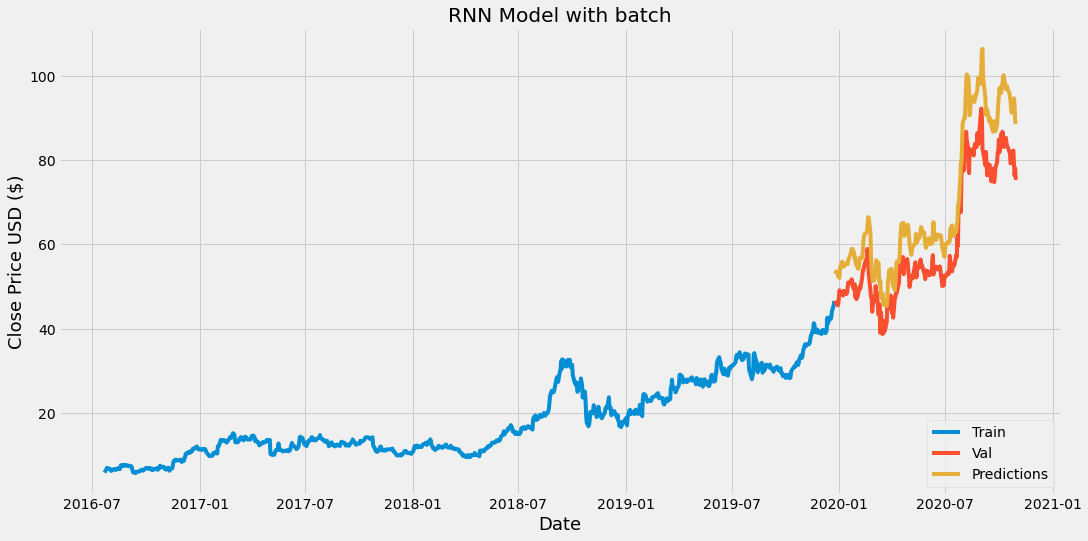

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('RNN Model with batch')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="blue">**SVM**</font>

**Build SVM model and train using training data**

In [ ]:
from sklearn import svm

In [ ]:
x_train_r=x_train.reshape(x_train.shape[0],x_train.shape[1])

clf = svm.SVR()
clf.fit(x_train_r, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

**Predict for SVM model and Visualize predictions**

In [ ]:
x_test_r=x_test.reshape(x_test.shape[0],x_test.shape[1])
preds = clf.predict(x_test_r)
preds = preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)#Undo scaling
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

37.55864936618268

In [ ]:
SVM_preds=preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


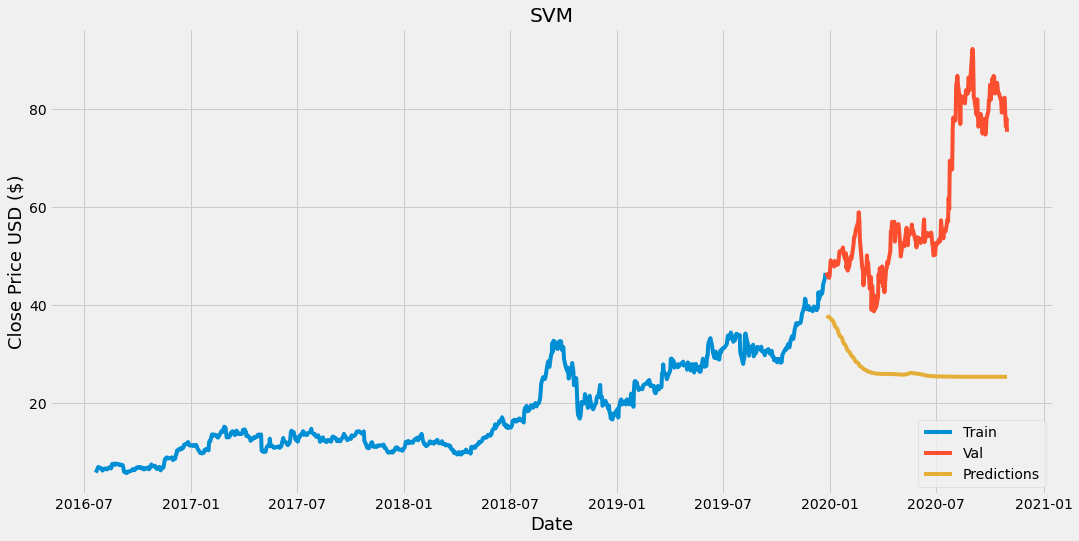

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('SVM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="green">**Ensemble model**</font>

**Compute predictions of ensemble model and visualize predictions**

In [ ]:
#Compute predictions
test_len=len(RNN_with_batch_preds)
finalpred=(LR_preds+LSTM_preds+RNN_preds)/3

In [ ]:
ensemble_rmse=np.sqrt(np.mean(((finalpred- y_test)**2)))
ensemble_rmse

3.9112737551939154

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


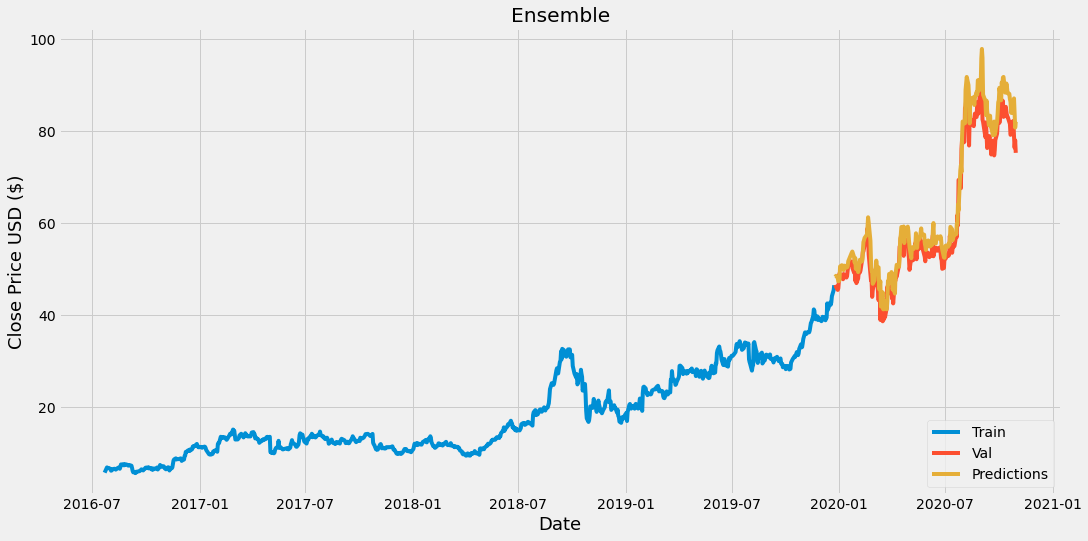

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = finalpred
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Ensemble')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="green">**Drift detection using ensemble**</font>

**Detect drift using ensemble and visualize drifts**

In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test, finalpred)
mae

3.2167041565116157

In [ ]:
#Find drift data
df1=df.reset_index()
datelist=[]
for i in range(len(y_test)):
  diff=abs(y_test[i]-finalpred[i])
  if(diff>(mae+2.5)):
    #print(df1.loc[training_data_len+i,"Date"])
    datelist.append(df1.loc[training_data_len+i,"Date"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


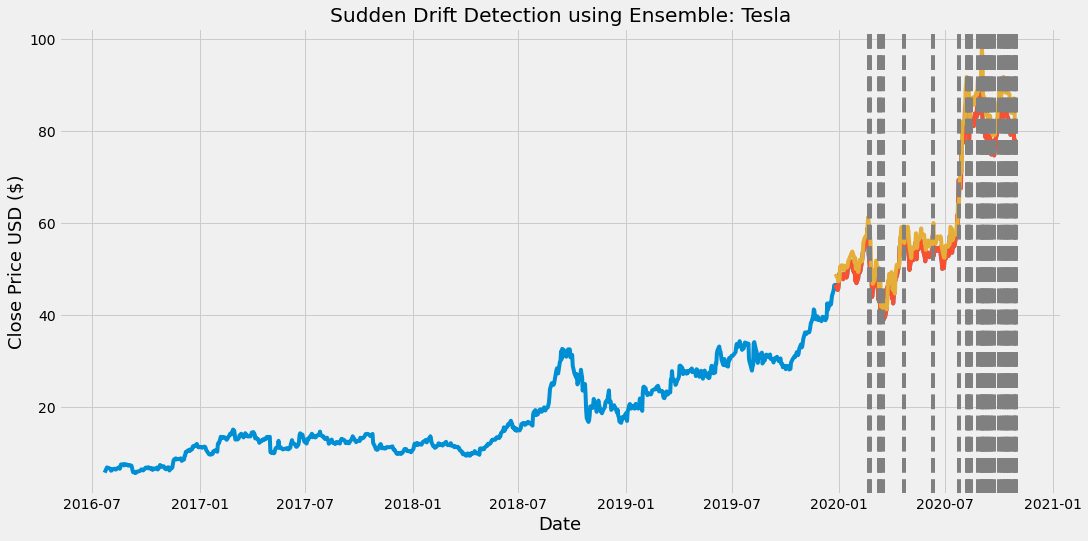

In [ ]:
#Plot data on graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = finalpred
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Sudden Drift Detection using Ensemble: Tesla')
plt.plot(df1['Date'],df1['Close'])
plt.plot(valid[['Close', 'Predictions']])
for i in range(len(datelist)):
  plt.axvline(pd.Timestamp(datelist[i]),color='gray',linestyle='--')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()